<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/Validating-the-input/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 299s 9s/step
Extracted Features (Shape): (1000, 2048)
Sample Features: [[0.0000000e+00 0.0000000e+00 1.1112690e-03 ... 1.7276372e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.6209084e-04 ... 1.7365489e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.7001467e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 3.3789752e-03 ... 1.8587266e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 5.7270331e-04 ... 1.7484030e+00
  0.0000000e+00 0.0000000e+00]]


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarnin

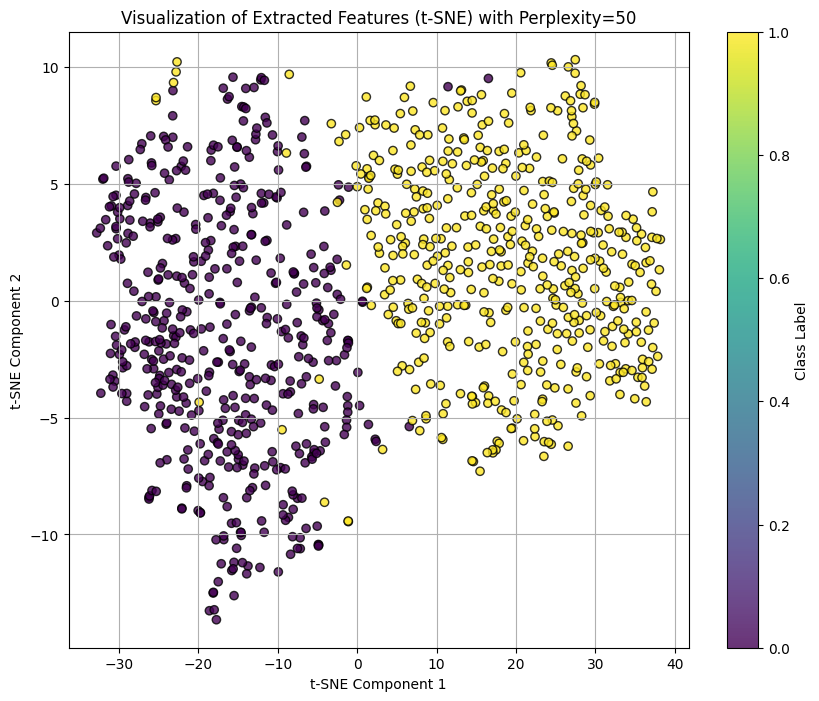

In [15]:
data_dir = "/content/drive/My Drive/DSGP/Data"
IMG_SIZE = (224, 224)  # Image size for ResNet50
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values
    rotation_range=20,    # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,      # Shear transformations
    zoom_range=0.2,       # Random zoom
    horizontal_flip=True  # Random horizontal flip
)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    shuffle=False  # Ensure consistent order for labels
)

# Load ResNet50 model without the top (fully connected) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add Global Average Pooling layer for feature extraction
feature_extractor = Model(
    inputs=base_model.input,
    outputs=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
)

# Extract features from images
features = feature_extractor.predict(train_data, verbose=1)

# Get class labels from train_data
labels = train_data.classes

print("Extracted Features (Shape):", features.shape)
print("Sample Features:", features[:5])  # Display the first 5 feature vectors

# t-SNE Hyperparameter Tuning
best_perplexity = None
best_tsne = None
best_score = float('inf')  # Initialize the best score for inertia or separation measure

# Tune perplexity and learning rate
for perplexity in [10, 30, 50]:  # Test multiple perplexities
    for learning_rate in [10, 100, 200]:
        tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=1000, random_state=42)
        reduced_features_tsne = tsne.fit_transform(features)
        # Evaluate separation (or add a domain-specific metric)
        current_score = np.mean(reduced_features_tsne.std(axis=0))  # Example metric
        if current_score < best_score:
            best_score = current_score
            best_perplexity = perplexity
            best_tsne = reduced_features_tsne

# Visualize the best t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    best_tsne[:, 0],
    best_tsne[:, 1],
    c=labels,
    cmap='viridis',
    alpha=0.8,
    edgecolor='k'
)
plt.colorbar(scatter, label='Class Label')
plt.title(f'Visualization of Extracted Features (t-SNE) with Perplexity={best_perplexity}')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split the extracted features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest Classifier on the extracted features
rf_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
print("Random Forest Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))




Random Forest Classifier Performance:
Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       100
           1       0.98      0.98      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200


Confusion Matrix:
 [[98  2]
 [ 2 98]]
